In [2]:
import json
import numpy as np
import pylab as pl

def waveform(f, A, b, t0, tend, d_end_t=None, gamma=0.0, phi0=0.0, 
             N=1000, verbose=False, seed_number=None, project_name=None):
    """
    METHOD
    ======
    Takes input parameters of a wave and the strength and duration of
    noise, and returns the data.
    PARAMETERS
    ==========
    f : (Float) Frequency of the signal
    A : (Float) Amplitude of the signal
    b : (Float) Amplitude of the noise
    t0 : (Float) Timestamp of the beginning of the signal
    tend : (Float) Time stamp of the end of the signal
    d_end_t : (Float) Time stamp of the end time of the data. Default = None
    gamma : (Float) Attenuation factor of the signal. Default = 0.0
    phi0 : (Float) Initial phase of the signal. Default = 0.0
    N : (Int) Total number of time stamps. Default = 1000
    verbose: (Bool) Set True to get diagnostic stdout. Default = False
    seed_number: (Int) Number set to seed noise. Default = None
    project_name: (String) Name given to png and json file created. Default = None
    OUTPUT
    ======
    A tuple of a float and two numpy arrays (dt, T_full, d), where dt is 
    the resolution of the time series. T_full is the full list of time stamps
    of the data starting at 0 and ending and d_end_t, and d is the 
    corresponding displacement values in the data.
    """
    
    # Conditional for noise duration
    # If the data-end time is supplied to be too small:
    if verbose:
        print("Making sure that the stretch of data is longer than signal")
    assert t0 > 0, "Signal should start later than t=0"
    if (d_end_t is None) or (tend > d_end_t - 10):
        d_end_t = tend + 10
        if verbose:
            print("data end time is set at {}".format(d_end_t))
    
    T = np.linspace(t0, tend, N) # Time stamps of signal
    dt = np.mean(np.diff(T)) # figuring out the resolution of the series
    if verbose:
        print("Mean value of timing resolution = {}".format(dt))
    
    t = t0 # Initializing the time series at the start time
    t_minus = [] # To populate time stamps prior to the signal start
    while t >= 0: # Making sure that we reach all the way back to zero.
        t = t - dt
        t_minus.append(t)  # Create time spamps from (t0-dt) to 0

    t_minus = np.array(t_minus)[::-1]  # Reverse to be from 0 to t0
    t_minus = t_minus[t_minus >= 0]  # Eliminate numbers less than 0
    
    t_plus = np.arange(tend+dt, d_end_t, dt)  # Time stamps from (tend+dt) to d_end_t, in dt's
    
    T_full = np.hstack((t_minus, T, t_plus))  # Connect time stamps
    
    dev = np.std(np.diff(T_full))  # Standard deviation in dt's of T_full
    if verbose:
        print("Standard deviation of the resolution of time = {}".format(dev))

    if verbose:
        print("Creating time series of the signal...")
    w = 2 * np.pi * f  
    y = A*np.sin(w*T + phi0)*np.exp(-gamma*(T-t0))

    
    # Padding of signal data
    if verbose:
        print("Creating the zero-padded signal...")
    y_minus = np.zeros_like(t_minus)
    y_plus = np.zeros_like(t_plus)
    y_full = np.hstack((y_minus, y, y_plus))
    
    if verbose:
        print("Creating random noise...")
    if seed_number is None:
        seed_number = 1
    np.random.seed(seed = seed_number)
    noise = -b+2*b*np.random.random(len(T_full))  # Noise!
    
    if verbose:
        print("Creating final data")
    d = noise + y_full  # Complete Data!
    
    # Graphing   
    pl.rcParams.update({'font.size': 18})
    pl.figure(figsize=(20,15))
    pl.plot(T_full, noise, color = 'green', linewidth=2)  # Noise
    pl.plot(T_full, d, color = 'black', linewidth=2)  # Combined
    pl.plot(T, y, color = 'orange', linewidth=2)  # Signal
    pl.xlabel("Time")
    pl.ylabel("displacement")
    text = "f={}; A={}; b={}; t0={}; tend={}; gamma={}; N={}"
    pl.title(text.format(f, A, b, t0, tend, gamma, N))
    #if project_name is None:
    #    project_name = "test"
    #pl.savefig("figures/{}-waveform_plot-f_{}-A_{}-b_{}-t0_{}-tend_{}-gamma_{}-seed_{}.png".format(project_name, f, A, b, t0, tend, gamma, seed_number))
    
    T_full = list(T_full)
    d = list(d)
    data = {"dt" : dt, "t_full" : T_full, "d" : d}
    outputfile = "{}.json".format(project_name)
    with open(outputfile, "w") as f:
        json.dump(data, f, indent=2, sort_keys=True)

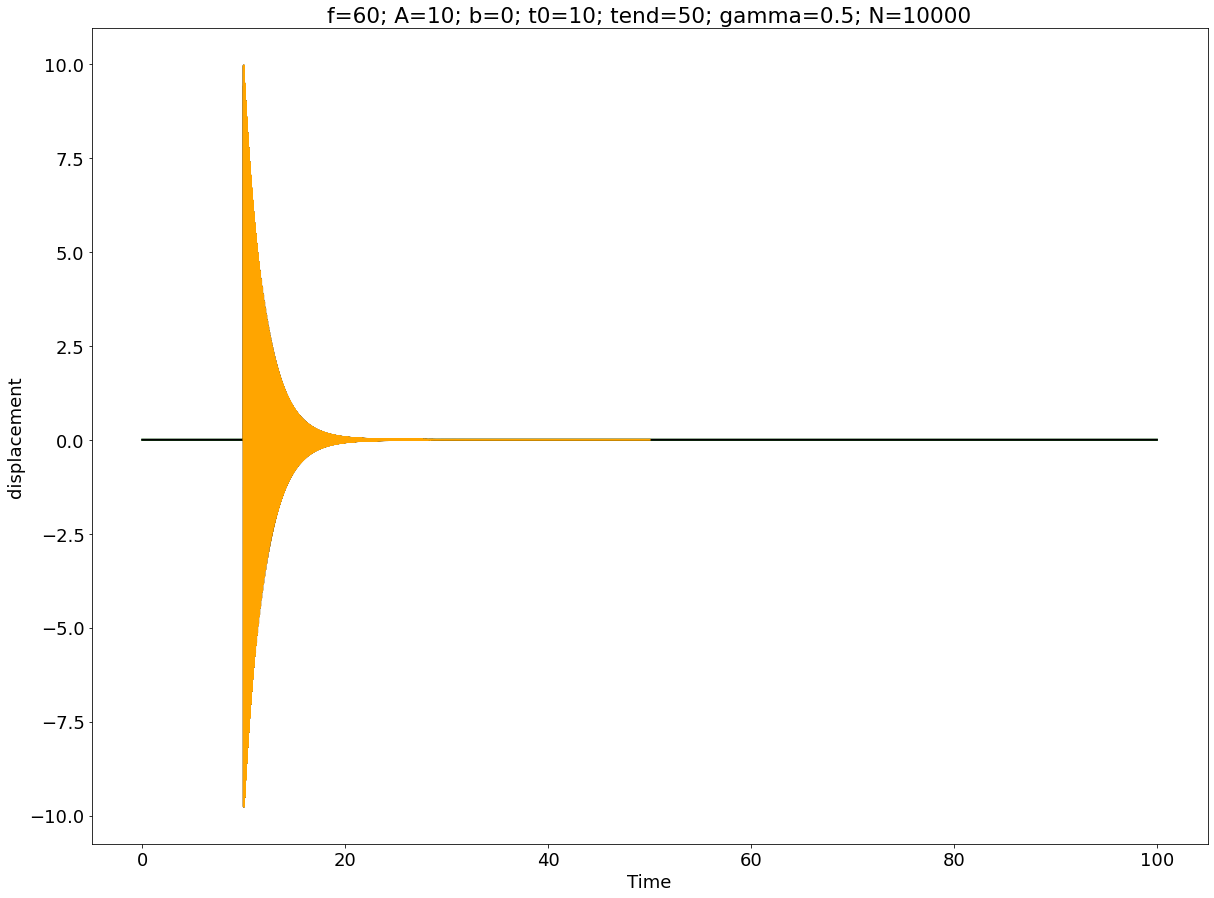

In [91]:
# def waveform(f, A, b, t0, tend, d_end_t=None, gamma=0.0, phi0=0.0, 
#              N=1000, verbose=False, seed_number=None, project_name=None):
waveform(60,10,0,10,50,d_end_t=100,gamma=.5,N=10000,project_name="b_0-waveform")

In [88]:
import json
import numpy as np
import pylab as pl
#from numba import jit

#@jit(nopython=True)
def match(data, template, dt):
        
    ii = 0
    time_slides = []
    M = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)
        
        M.append(np.sum((data[ii: len(template) + ii] * template)))
        ii += 1
        
    M = np.array(M)
    time_slides = np.array(time_slides)
        
    return(time_slides, M)

class Crosscor:
    def __init__(self, filename):
        with open(filename, "r") as f:
            data = json.load(f)
        self.dt = data["dt"]
        self.tfull = np.array(data["t_full"])
        self.d = np.array(data["d"])

    def template(self, f, gamma, duration):
        
        t = np.arange(0, duration + self.dt, self.dt)
        self.t = t
        w = 2 * np.pi * f
        self.y = np.sin(w*t)*np.exp(-gamma*t)

def search(f_low, f_hi, gamma_low, gamma_hi, datafile,
           tmplt_dur, outputfile, df=1.0, dg=0.1):
    """
    METHOD: Takes as input the upper and lower values of frequency 
    and gammas, constructs a bank of templates using this range of values, 
    and then computes the maximum of the match for each templates in the 
    bank and its corresponding time and returns that
    PARAMETERS:
    -----------
    f_low: Lower bound of the frequency grid
    f_hi: Upper bound of the frequency grid
    gamma_low: Lower bound of the gamma grid
    gamma_hi: Upper bound of the gamma grid
    datafile: The JSON file with the data time series
    tmplt_dur: The duration of the templates
    df: Step-size in frequency (default = 1.0)
    dg: Step-size in gamma (default = 0.1)
    outputfile: The txt file with the two dimensional search results
    """
    f = np.arange(f_low, f_hi+df, df)
    g = np.arange(gamma_low, gamma_hi + dg, dg)

    fs = []
    gs = []
    Ms = []
    Ts = []

    Obj = Crosscor(datafile)
    for i in f:
        for j in g:
            Obj.template(i, j, tmplt_dur)
            t, m = match(Obj.d, Obj.y, Obj.dt)
            
    output = np.vstack((t,m)).T
    outputfile = "{}.txt".format(outputfile)
    np.savetxt(outputfile, output, fmt="%f\t%f")

def timeplot(txtfile,plotfile):
    """
    METHOD: Takes as input the search function's outputfile, loads it, then
    isolates the time and match values to use as the x and y of the plot
    
    PARAMETERS:
    ----------
    txtfile: (txt) File that holds frequency, gamma, time, and match values
    plotfile: (png) Plot of the time and match values of provided file
    """
    results = np.loadtxt(txtfile)
    t = results[:,0]
#     m_array = np.abs(results[:,1])
    m = results[:,1]
    pl.rcParams.update({'font.size':18})
    pl.figure(figsize=(20,15))
    pl.plot(t, m, linewidth=2)
    pl.xlabel("Time")
    pl.ylabel("Match")
    pl.savefig("{}.png".format(plotfile))
    

In [89]:
search(60,60,.5,.5,"b_0-waveform.json", 40, "b_0-waveform-results")

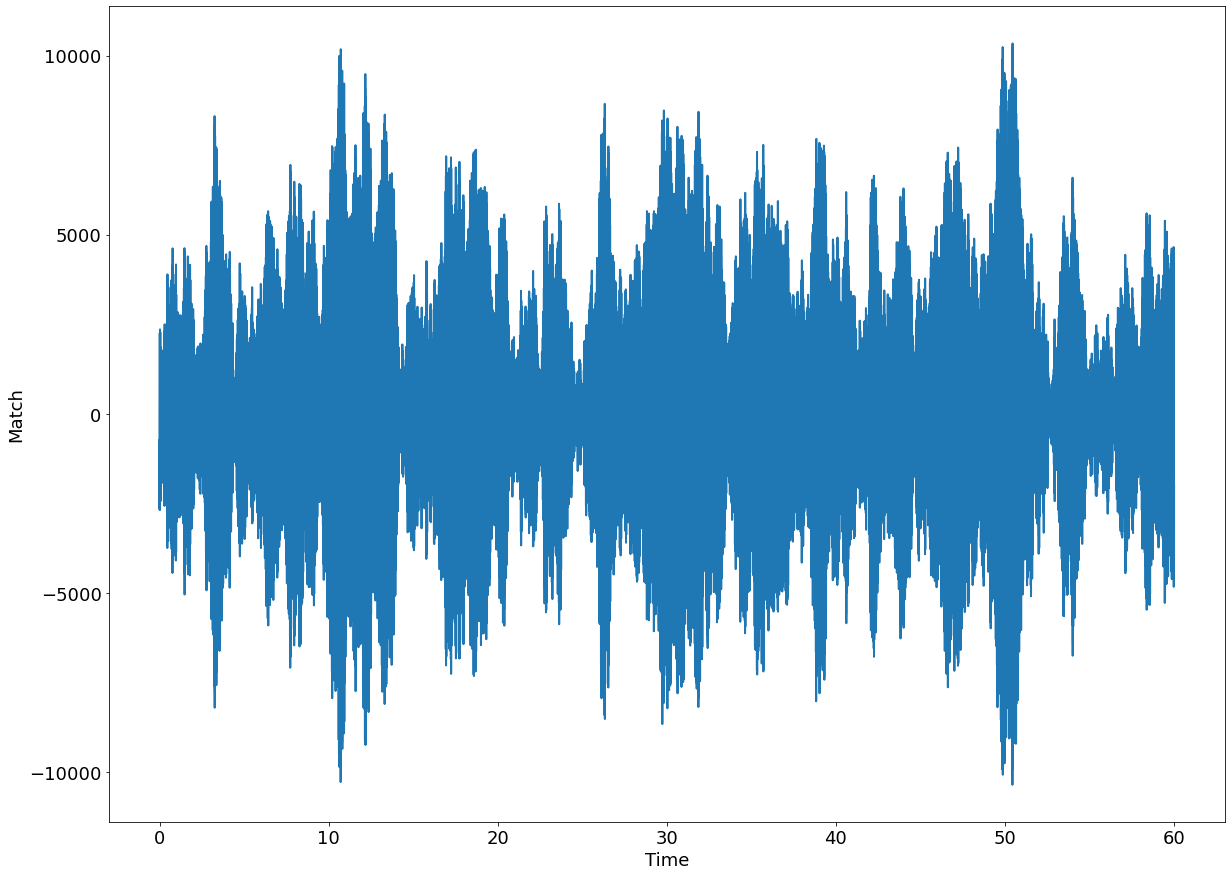

In [90]:
# Time Match Plot
timeplot("b_0-waveform-results.txt","b_0-waveform-t0_plot")

In [29]:
import json
import numpy as np
import pylab as pl
#from numba import jit

#@jit(nopython=True)
def match(data, template, dt):
        
    ii = 0
    time_slides = []
    M = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)
        
        M.append(np.sum((data[ii: len(template) + ii] * template)))
        ii += 1
        
    M = np.array(M)
    time_slides = np.array(time_slides)
        
    return(time_slides, M)

def ChiSquare(data, template, dt):

    ii = 0
    time_slides = []
    C = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)

        C.append(np.sum((data[ii:len(template) + ii] - template) ** 2))
        ii += 1
        
    return(time_slides, C)

def Rho(data, template, dt):

    ii = 0
    time_slides = []
    R = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)

        R.append(np.sum((data[ii: len(template) + ii] * template) / (1 + ((data[ii:len(template) + ii] - template) ** 2))))
        ii += 1
        
    return(time_slides, R)

class Crosscor:
    def __init__(self, filename):
        with open(filename, "r") as f:
            data = json.load(f)
        self.dt = data["dt"]
        self.tfull = np.array(data["t_full"])
        self.d = np.array(data["d"])

    def template(self, f, gamma, duration):
        
        t = np.arange(0, duration + self.dt, self.dt)
        self.t = t
        w = 2 * np.pi * f
        self.y = 10*np.sin(w*t)*np.exp(-gamma*t)
    
def search(f_low, f_hi, gamma_low, gamma_hi, datafile,
           tmplt_dur, outputfile, df=1.0, dg=0.1):
    """
    METHOD: Takes as input the upper and lower values of frequency 
    and gammas, constructs a bank of templates using this range of values, 
    and then computes the maximum of the match for each templates in the 
    bank and its corresponding time and returns that
    PARAMETERS:
    -----------
    f_low: Lower bound of the frequency grid
    f_hi: Upper bound of the frequency grid
    gamma_low: Lower bound of the gamma grid
    gamma_hi: Upper bound of the gamma grid
    datafile: The JSON file with the data time series
    tmplt_dur: The duration of the templates
    df: Step-size in frequency (default = 1.0)
    dg: Step-size in gamma (default = 0.1)
    outputfile: The txt file with the two dimensional search results
    """
    f = np.arange(f_low, f_hi+df, df)
    g = np.arange(gamma_low, gamma_hi + dg, dg)

    fs = []
    gs = []
    Ms = []
    Ts = []

    Obj = Crosscor(datafile)
    for i in f:
        for j in g:
            Obj.template(i, j, tmplt_dur)
            t, m = match(Obj.d, Obj.y, Obj.dt)
            M = m[np.argmax(m)] # Max match
            T = t[np.argmax(m)] # Time associated with max match
            fs.append(i)
            gs.append(j)
            Ts.append(T)
            Ms.append(M)

    output = np.vstack((fs,gs,Ts,Ms)).T
    outputfile = "{}.txt".format(outputfile)
    np.savetxt(outputfile, output, fmt="%f\t%f\t%f\t%f")
    
    max_index = np.argmax(Ms)
    Maxm = Ms[max_index]
    Maxt = Ts[max_index]
    Maxg = gs[max_index]
    Maxf = fs[max_index]

    return(Maxf, Maxg, Maxt, Maxm)
#search(90,105,0,1,"newdatafile.json"

def heatmap(txtfile,plotfile):
    """
    METHOD: Takes as input a txt with all the frequency, gamma, time,
    and match results. This txt
    PARAMETERS:
    -----------
    txtfile: (String) Name of txt file holding f, g, t, m values
    plotfile: (String) Name given to created heatmap
    """
    results = np.loadtxt(txtfile)
    f = results[:,0]
    g = results[:,1]
    m = results[:,3]
    print(f)
    print(g)
    print(m)
    f = np.unique(f)
    g = np.unique(g)
    F,G = np.meshgrid(f,g)
    M = np.reshape(m, (-1, len(f)))
    pl.pcolormesh(F,G,M)
    pl.colorbar()
    pl.show()
    print(F)
    print(G)
    print(M)

In [30]:
search(55,65,0,1,"b_0-waveform.json", 40, "b_0-waveform-results")

(60.0, 0.0, 9.996999699969997, 24997.483181660245)

[55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 56. 56. 56. 56. 56. 56. 56.
 56. 56. 56. 56. 57. 57. 57. 57. 57. 57. 57. 57. 57. 57. 57. 58. 58. 58.
 58. 58. 58. 58. 58. 58. 58. 58. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59.
 59. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 61. 61. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 63. 63.
 63. 63. 63. 63. 63. 63. 63. 63. 63. 64. 64. 64. 64. 64. 64. 64. 64. 64.
 64. 64. 65. 65. 65. 65. 65. 65. 65. 65. 65. 65. 65.]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6
 0.7 0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2
 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5
 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1
 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8
 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[  400.427352   

<ipython-input-29-c8df07c1e245>:139: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(F,G,M)


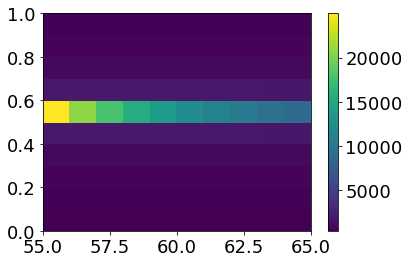

[[55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
 [0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  1.  1.

In [31]:
heatmap("b_0-waveform-results.txt","test") # CC

In [92]:
import json
import numpy as np
import pylab as pl
#from numba import jit

#@jit(nopython=True)
def match(data, template, dt):
        
    ii = 0
    time_slides = []
    M = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)
        
        M.append(np.sum((data[ii: len(template) + ii] * template)))
        ii += 1
        
    M = np.array(M)
    time_slides = np.array(time_slides)
        
    return(time_slides, M)

def ChiSquare(data, template, dt):

    ii = 0
    time_slides = []
    C = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)

        C.append(np.sum((data[ii:len(template) + ii] - template) ** 2))
        ii += 1
        
    return(time_slides, C)

def Rho(data, template, dt):

    ii = 0
    time_slides = []
    R = []
        
    while len(data[ii:]) >= len(template):
        time_slides.append(ii*dt)

        R.append(np.sum((data[ii: len(template) + ii] * template) / (1 + ((data[ii:len(template) + ii] - template) ** 2))))
        ii += 1
        
    return(time_slides, R)

class Crosscor:
    def __init__(self, filename):
        with open(filename, "r") as f:
            data = json.load(f)
        self.dt = data["dt"]
        self.tfull = np.array(data["t_full"])
        self.d = np.array(data["d"])

    def template(self, f, gamma, duration):
        
        t = np.arange(0, duration + self.dt, self.dt)
        self.t = t
        w = 2 * np.pi * f
        self.y = 10*np.sin(w*t)*np.exp(-gamma*t)
    
def search(f_low, f_hi, gamma_low, gamma_hi, datafile,
           tmplt_dur, outputfile, df=1.0, dg=0.1):
    """
    METHOD: Takes as input the upper and lower values of frequency 
    and gammas, constructs a bank of templates using this range of values, 
    and then computes the maximum of the match for each templates in the 
    bank and its corresponding time and returns that
    PARAMETERS:
    -----------
    f_low: Lower bound of the frequency grid
    f_hi: Upper bound of the frequency grid
    gamma_low: Lower bound of the gamma grid
    gamma_hi: Upper bound of the gamma grid
    datafile: The JSON file with the data time series
    tmplt_dur: The duration of the templates
    df: Step-size in frequency (default = 1.0)
    dg: Step-size in gamma (default = 0.1)
    outputfile: The txt file with the two dimensional search results
    """
    f = np.arange(f_low, f_hi+df, df)
    g = np.arange(gamma_low, gamma_hi + dg, dg)

    fs = []
    gs = []
    Ms = []
    Ts = []

    Obj = Crosscor(datafile)
    for i in f:
        for j in g:
            Obj.template(i, j, tmplt_dur)
            t, m = match(Obj.d, Obj.y, Obj.dt)
            M = m[np.argmax(m)] # Max match
            T = t[np.argmax(m)] # Time associated with max match
            fs.append(i)
            gs.append(j)
            Ts.append(T)
            Ms.append(M)

    output = np.vstack((fs,gs,Ts,Ms)).T
    outputfile = "{}.txt".format(outputfile)
    np.savetxt(outputfile, output, fmt="%f\t%f\t%f\t%f")

#search(90,105,0,1,"newdatafile.json"

def gammaplot(txtfile,plotfile):
    """
    METHOD: Takes as input the search function's outputfile, loads it, then
    isolates the gamma and match values to use as the x and y of the plot
    
    PARAMETERS:
    ----------
    txtfile: (txt) File that holds frequency, gamma, time, and match values
    plotfile: (png) Plot of the gamma and match values of provided file
    """
    results = np.loadtxt(txtfile)
    g_array = results[:,1]
    m_array = results[:,3]
    pl.rcParams.update({'font.size':18})
    pl.figure(figsize=(20,15))
    pl.plot(g_array,m_array, linewidth=2)
    pl.xlabel("Gamma")
    pl.ylabel("Match")
    pl.show()
    pl.savefig("{}.png".format(plotfile))

In [93]:
search(60,60,0,1,"b_0-waveform.json", 40, "b_0-waveform-results",dg=.01) # gamma amplitude plot CC

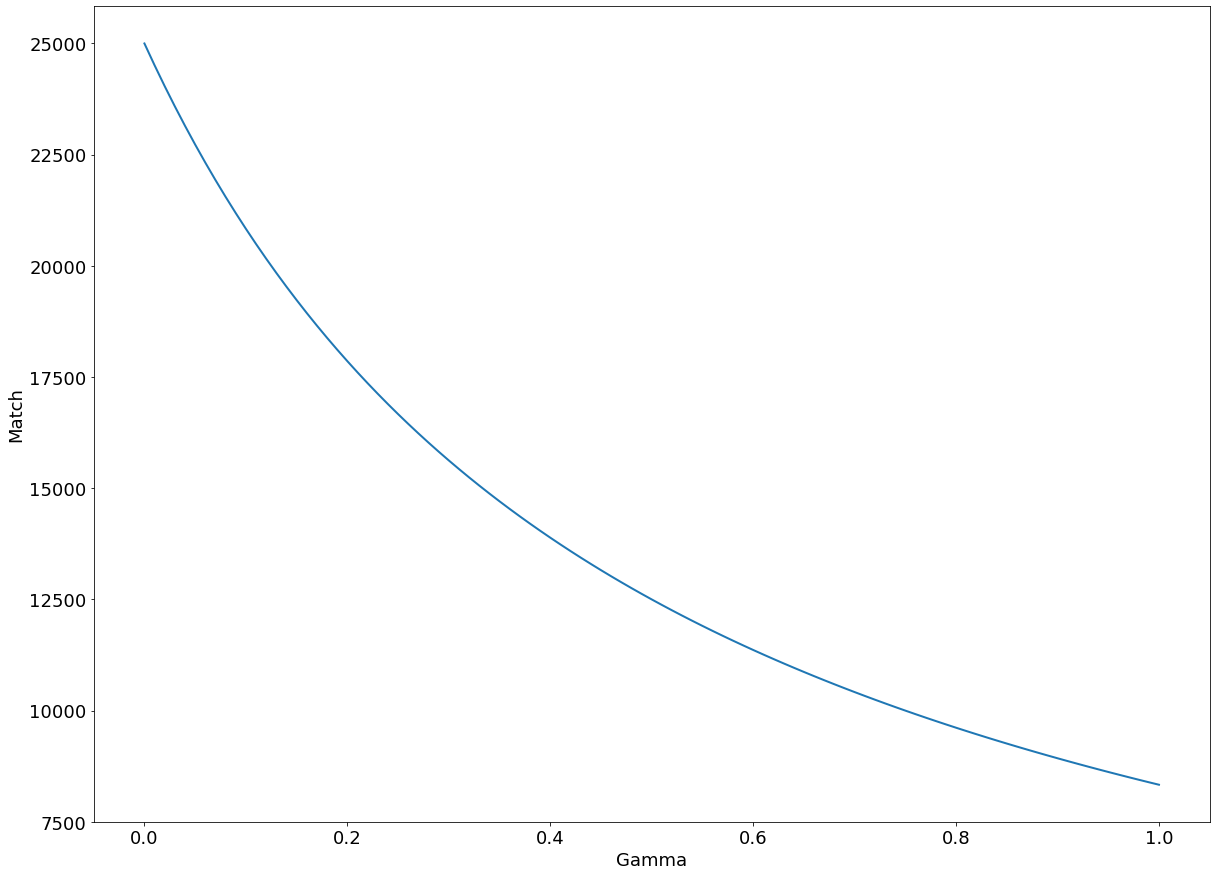

<Figure size 432x288 with 0 Axes>

In [94]:
#Gamma-Match Plot
gammaplot("b_0-waveform-results.txt","test")